# Semana 1: Exploración del problema y del dataset

## 1. Cargar y visualizar señales ECG

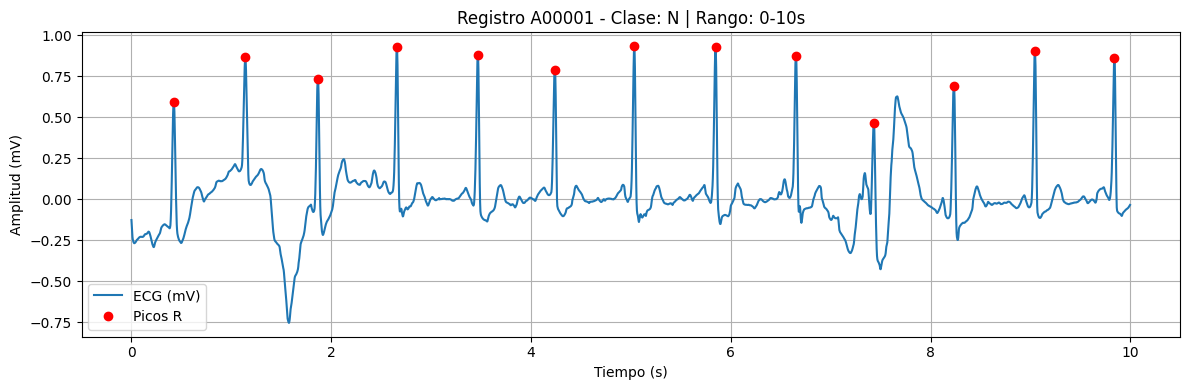

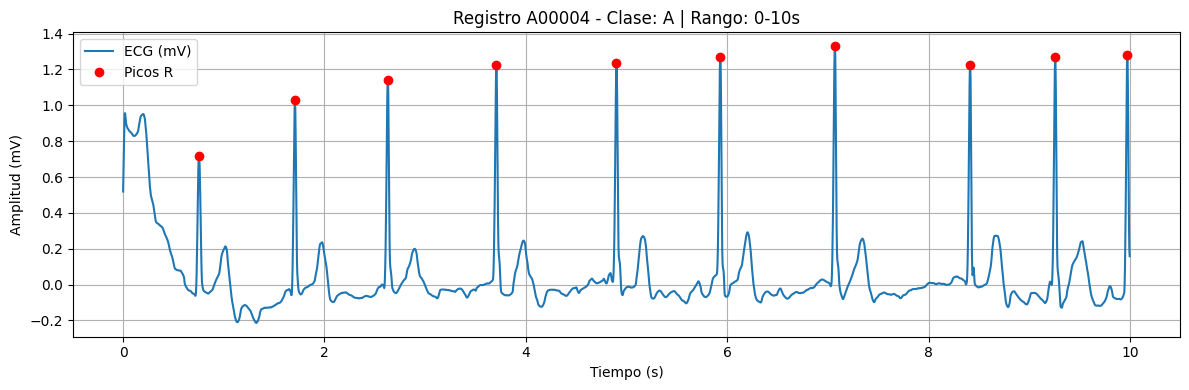

In [1]:
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import os
import pandas as pd
import scipy.io
from scipy.stats import kurtosis, skew
import wfdb

# Configuración general para la visualización
base_path = '../data/training2017'
records = ['A00001', 'A00004']
start_sec = 0 
end_sec = 10 

# Cargar etiquetas
csv_labels = pd.read_csv(os.path.join(base_path, 'REFERENCE.csv'), header=None, names=['record', 'label'])

for record_name in records:
    # Cargar señal .mat. Es un array de enteros, donde cada valor es un punto de la señal en el tiempo
    mat_file = os.path.join(base_path, f'{record_name}.mat')
    mat_data = scipy.io.loadmat(mat_file)
    signal = mat_data['val'][0]

    # Header para metadatos: frecuencia de muestreo, factor de conversión, unidad fisiológica
    header = wfdb.rdheader(os.path.join(base_path, record_name))
    fs = header.fs
    gain = header.adc_gain[0]
    units = header.units[0]

    # Etiqueta de clase
    label = csv_labels.loc[csv_labels['record'] == record_name, 'label'].values[0]

    # Detección de picos R
    _, info = nk.ecg_peaks(signal, sampling_rate=fs)
    r_peaks = info["ECG_R_Peaks"]

    # Cálculos para realizar gráfico de la señal
    # Escalar la señal a milivoltios
    signal_mv = signal / gain

    # Índices de inicio y fin para la segmentación
    start_idx = int(start_sec * fs)
    end_idx = int(end_sec * fs)

    # Segmentar la señal y los picos R correspondientes
    signal_segment = signal_mv[start_idx:end_idx]
    time_segment = np.arange(start_idx, end_idx) / fs
    r_peaks_segment = r_peaks[(r_peaks >= start_idx) & (r_peaks < end_idx)] - start_idx

    # Graficar
    plt.figure(figsize=(12, 4))
    plt.plot(time_segment, signal_segment, label="ECG (mV)")
    plt.plot(time_segment[r_peaks_segment], signal_segment[r_peaks_segment], 'ro', label="Picos R")
    plt.title(f"Registro {record_name} - Clase: {label} | Rango: {start_sec}-{end_sec}s")
    plt.xlabel("Tiempo (s)")
    plt.ylabel(f"Amplitud ({units})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 2. Resumen del artículo base (Clifford et al., 2017)

La fibrilación auricular (AF) es la arritmia cardíaca sostenida más común y se caracteriza por una actividad eléctrica auricular desorganizada que impide la contracción efectiva de las aurículas. Desde el punto de vista electrocardiográfico, la AF se manifiesta por la ausencia de ondas P bien definidas y por una irregularidad en los intervalos RR, es decir, los intervalos entre latidos consecutivos. Esta irregularidad en los tiempos entre complejos QRS es uno de los indicadores más confiables de la presencia de AF, especialmente en registros de una sola derivación.

La importancia clínica de detectar AF radica en que está fuertemente asociada a un mayor riesgo de accidentes cerebrovasculares, insuficiencia cardíaca, deterioro cognitivo y muerte. Su prevalencia aumenta con la edad, alcanzando hasta un 15 % en adultos mayores. A menudo, la fibrilación auricular es asintomática o paroxística, lo que complica su diagnóstico oportuno. Se considera suficiente una grabación de al menos 30 segundos de fibrilación auricular documentada en ECG para confirmar el diagnóstico. Por esto, la monitorización continua con dispositivos portátiles es una herramienta clave para la detección temprana.

En ese contexto, el PhysioNet/CinC Challenge 2017 propuso el desarrollo de algoritmos automáticos capaces de detectar AF a partir de grabaciones cortas de ECG (30 a 60 segundos) de una sola derivación, simulando las condiciones reales de uso de dispositivos portátiles. El objetivo era clasificar cada grabación en una de cuatro clases: ritmo sinusal normal (N), fibrilación auricular (A), otros ritmos (O), y señales no utilizables por ruido (~). Los algoritmos debían ser robustos frente a condiciones adversas como ruido, artefactos por movimiento, variabilidad interindividual y baja duración de la señal. Una característica central para muchos enfoques fue el análisis de la variabilidad de los intervalos RR, ya que en la fibrilación auricular estos intervalos tienden a ser altamente irregulares, mientras que en el ritmo sinusal son más regulares.

El conjunto de datos entregado incluía más de 12.000 grabaciones de ECG, todas de una sola derivación y con una frecuencia de muestreo de 300 Hz. De ellas, 8.528 estaban disponibles públicamente para entrenamiento y validación, mientras que otras 3.658 fueron utilizadas para la evaluación final. Las duraciones de las grabaciones iban de 9 a 61 segundos y representaban una amplia gama de condiciones reales. Las señales provenían de dispositivos portátiles utilizados en entornos ambulatorios, lo que implicaba la presencia de ruido de baja y alta frecuencia, interferencias mecánicas y artefactos de movimiento. Las etiquetas fueron asignadas por expertos clínicos, aunque algunas grabaciones ambiguas fueron reevaluadas debido a discrepancias entre anotadores.

## 3. Análisis del dataset (cantidad de señales, duración, etiquetas, etc.)


Tipos de datos en el archivo de etiquetas:
record    object
label     object
dtype: object

Clases:
label
N    5050
O    2456
A     738
~     284
Name: count, dtype: int64

Estadísticas:
Total de señales: 8528
Duración promedio: 32.50 s
Duración mínima: 9.05 s
Duración máxima: 60.95 s
Frecuencia de muestreo: {300} Hz
Señales con error: 0


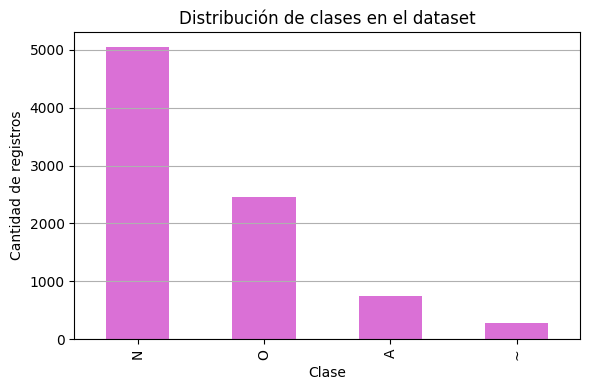

In [2]:
# Explorar tipos de datos en el archivo de etiquetas
print("\nTipos de datos en el archivo de etiquetas:")
print(csv_labels.dtypes)

# Clases y cantidad de registros por clase 
print("\nClases:")
print(csv_labels['label'].value_counts())

durations = [] # Duraciones
frequencies = [] # Frecuencias de muestreo
errors = [] # Registros con errores

# Recorrer todos los registros, recopilando estadísticas
for rec in csv_labels['record']:
    try:
        header = wfdb.rdheader(os.path.join(base_path, rec))
        fs = header.fs
        sig_len = header.sig_len
        durations.append(sig_len / fs)
        frequencies.append(fs)
    except Exception as e:
        errors.append(rec)

# Mostrar estadísticas básicas
print("\nEstadísticas:")
print(f"Total de señales: {len(durations)}")
print(f"Duración promedio: {np.mean(durations):.2f} s")
print(f"Duración mínima: {np.min(durations):.2f} s")
print(f"Duración máxima: {np.max(durations):.2f} s")
print(f"Frecuencia de muestreo: {set(frequencies)} Hz")
print(f"Señales con error: {len(errors)}")

# Visualizar distribución de clases
plt.figure(figsize=(6, 4))
csv_labels['label'].value_counts().plot(kind='bar', color='orchid')
plt.title('Distribución de clases en el dataset')
plt.xlabel('Clase')
plt.ylabel('Cantidad de registros')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 3. Extracción de estadísticas

In [3]:
output_csv = '../data/ecg_rr_features_curado.csv' # Ruta de salida para el CSV con estadísticas de intervalos RR
estadisticas = []
csv_labels = csv_labels[csv_labels['label'].isin(['N', 'A'])]  # Filtrar etiquetas normales y fibrilación auricular

for _, row in csv_labels.iterrows():
    record = row['record']
    label = row['label']

    try:
        # Cargar señal .mat
        mat_data = scipy.io.loadmat(os.path.join(base_path, f'{record}.mat'))
        signal = mat_data['val'][0]

        # Detectar picos R y calcular intervalos RR
        _, info = nk.ecg_peaks(signal, sampling_rate=fs)
        r_peaks = info["ECG_R_Peaks"]
        rr = np.diff(r_peaks) / fs * 1000  

        # Ignorar registros con muy pocos picos R
        if len(rr) < 10:
            print(f"{record}: Se detectaron muy pocos picos R ({len(rr)})")
            continue

        # Calcular estadísticas de los intervalos RR
        estadisticas.append({
            'record': record,
            'mean_rr': np.mean(rr),
            'std_rr': np.std(rr),
            'skew_rr': skew(rr),
            'kurt_rr': kurtosis(rr),
            'label': label
        })

    except Exception as e:
        print(f"{record}: {e}")

# Guardar CSV
df_rr = pd.DataFrame(estadisticas)
df_rr.to_csv(output_csv, index=False)
print(f"\n{output_csv} {len(df_rr)} registros")


A00112: Se detectaron muy pocos picos R (9)
A00516: Se detectaron muy pocos picos R (9)
A00900: Se detectaron muy pocos picos R (8)
A01364: Se detectaron muy pocos picos R (8)
A02229: Se detectaron muy pocos picos R (9)
A03507: Se detectaron muy pocos picos R (9)
A04191: Se detectaron muy pocos picos R (8)
A04396: Se detectaron muy pocos picos R (9)
A05780: Se detectaron muy pocos picos R (6)
A07250: Se detectaron muy pocos picos R (9)
A07595: Se detectaron muy pocos picos R (7)
A07661: Se detectaron muy pocos picos R (3)
A07769: Se detectaron muy pocos picos R (0)
A08485: Se detectaron muy pocos picos R (8)

../data/ecg_rr_features_curado.csv 5774 registros
